In [ ]:
Name - mukul negi
task by

## 2️⃣ Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import os

# ML Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix,
                             roc_auc_score, roc_curve)

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print("=" * 80)

✅ All libraries imported successfully!


## 3️⃣ Load Datasets

In [ ]:
# Load trader data
print("[STEP 1] Loading Datasets...")
trader_df = pd.read_csv('csv_files/historical_data.csv')
print(f"✓ Trader Data Shape: {trader_df.shape}")

# Load sentiment data
sentiment_df = pd.read_csv('csv_files/fear_greed_index.csv')
print(f"✓ Sentiment Data Shape: {sentiment_df.shape}")

# Display samples
print("\n📊 Sample Trader Data:")
display(trader_df.head(3))
print("\n📊 Sample Sentiment Data:")
display(sentiment_df.head(3))

[STEP 1] Loading Datasets...
✓ Trader Data Shape: (211224, 16)
✓ Sentiment Data Shape: (2644, 4)

📊 Sample Trader Data:


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12



📊 Sample Sentiment Data:


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03


## 4️⃣ Data Cleaning and Preprocessing

In [ ]:
print("[STEP 2] Data Cleaning and Preprocessing...")

# Clean trader data
trader_df['Timestamp IST'] = pd.to_datetime(trader_df['Timestamp IST'], format='%d-%m-%Y %H:%M', errors='coerce')
trader_df['Date'] = trader_df['Timestamp IST'].dt.date
trader_df['Hour'] = trader_df['Timestamp IST'].dt.hour
trader_df['DayOfWeek'] = trader_df['Timestamp IST'].dt.dayofweek
trader_df['Month'] = trader_df['Timestamp IST'].dt.month

# Clean sentiment data
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
sentiment_df['Date'] = sentiment_df['date'].dt.date

# Remove rows with missing critical data
trader_df = trader_df.dropna(subset=['Closed PnL', 'Timestamp IST'])
print(f"✓ Cleaned Trader Data Shape: {trader_df.shape}")

# Memory optimization - delete raw columns we don't need
import gc
gc.collect()
print("✓ Memory optimized")

[STEP 2] Data Cleaning and Preprocessing...
✓ Cleaned Trader Data Shape: (211224, 20)
✓ Memory optimized


## 5️⃣ Feature Engineering

In [ ]:
print("[STEP 3] Feature Engineering...")

# Aggregate trader data by date
trader_daily = trader_df.groupby('Date').agg({
    'Size USD': ['mean', 'sum', 'std', 'count'],
    'Closed PnL': ['mean', 'sum', 'std'],
    'Execution Price': ['mean', 'std'],
    'Fee': 'sum',
    'Hour': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.mean()
}).reset_index()

# Flatten column names
trader_daily.columns = ['_'.join(col).strip('_') if col[1] else col[0] for col in trader_daily.columns.values]
trader_daily.rename(columns={'Date': 'Date'}, inplace=True)

# Calculate profitability metrics
trader_daily['avg_profit_per_trade'] = trader_daily['Closed PnL_mean']
trader_daily['total_daily_volume'] = trader_daily['Size USD_sum']
trader_daily['trade_frequency'] = trader_daily['Size USD_count']
trader_daily['volatility'] = trader_daily['Execution Price_std']
trader_daily['profit_volatility'] = trader_daily['Closed PnL_std']

print(f"✓ Aggregated Daily Data Shape: {trader_daily.shape}")

[STEP 3] Feature Engineering...
✓ Aggregated Daily Data Shape: (480, 17)


In [ ]:
# Calculate Buy/Sell ratio
side_counts = trader_df.groupby(['Date', 'Side']).size().unstack(fill_value=0)
if 'BUY' in side_counts.columns and 'SELL' in side_counts.columns:
    side_counts['buy_sell_ratio'] = side_counts['BUY'] / (side_counts['SELL'] + 1)
    trader_daily = trader_daily.merge(side_counts[['buy_sell_ratio']], left_on='Date', right_index=True, how='left')

# Clear memory
del side_counts
gc.collect()

print("✓ Buy/Sell ratio calculated")

✓ Buy/Sell ratio calculated


In [ ]:
# Merge with sentiment data
merged_df = trader_daily.merge(sentiment_df[['Date', 'value', 'classification']],
                                on='Date', how='inner')

print(f"✓ Merged Dataset Shape: {merged_df.shape}")
print(f"✓ Features created: {merged_df.shape[1]}")

# Create target variable
merged_df['is_profitable'] = (merged_df['Closed PnL_sum'] > 0).astype(int)
print(f"\n✓ Target Distribution:")
print(merged_df['is_profitable'].value_counts())

display(merged_df.head())

✓ Merged Dataset Shape: (479, 20)
✓ Features created: 20

✓ Target Distribution:
is_profitable
1    361
0    118
Name: count, dtype: int64


,Date,Size USD_mean,Size USD_sum,Size USD_std,Size USD_count,Closed PnL_mean,Closed PnL_sum,Closed PnL_std,Execution Price_mean,Execution Price_std,...,Hour_<lambda>,avg_profit_per_trade,total_daily_volume,trade_frequency,volatility,profit_volatility,buy_sell_ratio,value,classification,is_profitable
0,2023-05-01,159.000000,477.00,23.334732,3,0.000000,0.000000,0.000000,1898.133333,0.404145,...,1,0.000000,477.00,3,0.404145,0.000000,3.000000,63,Greed,0
1,2023-12-05,5556.203333,50005.83,7684.929083,9,0.000000,0.000000,0.000000,11038.300000,17477.946554,...,3,0.000000,50005.83,9,17477.946554,0.000000,2.333333,75,Extreme Greed,0
2,2023-12-14,10291.213636,113203.35,7791.138318,11,-18.675885,-205.434737,179.663534,8031.868818,17176.671271,...,23,-18.675885,113203.35,11,17176.671271,179.663534,0.714286,72,Greed,0
3,2023-12-15,5304.975000,10609.95,1927.254887,2,-12.316017,-24.632034,4.474304,2.982000,0.000000,...,0,-12.316017,10609.95,2,0.000000,4.474304,2.000000,70,Greed,0
4,2023-12-16,5116.256667,15348.77,797.042550,3,0.000000,0.000000,0.000000,0.384707,0.000029,...,9,0.000000,15348.77,3,0.000029,0.000000,3.000000,67,Greed,0


## 6️⃣ Exploratory Data Analysis (EDA)

[STEP 4] Creating Visualizations...


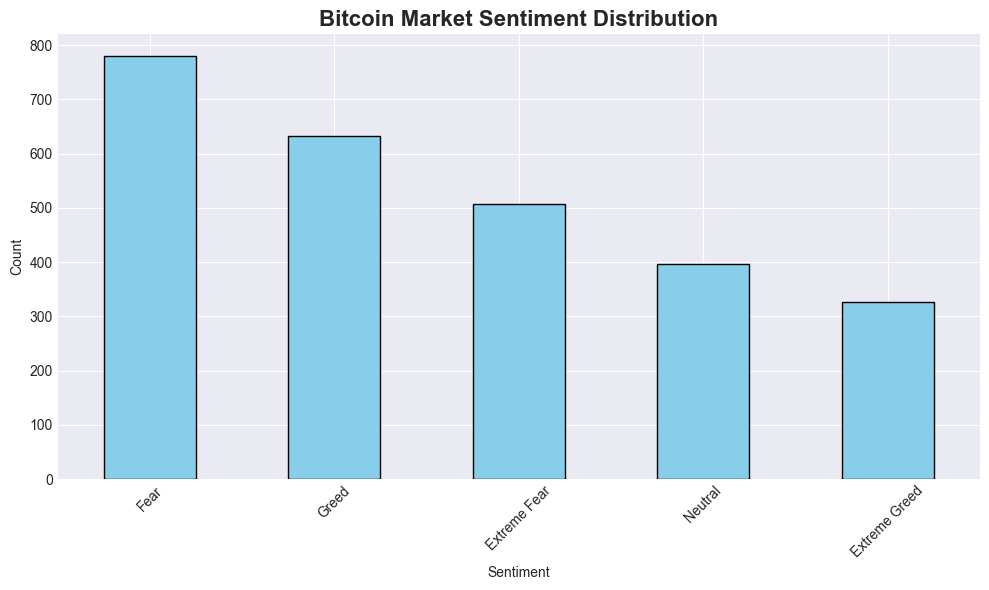

✓ Sentiment distribution chart saved


In [ ]:
print("[STEP 4] Creating Visualizations...")
os.makedirs('outputs', exist_ok=True)

# 1. Sentiment Distribution
plt.figure(figsize=(10, 6))
sentiment_df['classification'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Bitcoin Market Sentiment Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('outputs/01_sentiment_distribution.png', dpi=300)
plt.show()
print("✓ Sentiment distribution chart saved")

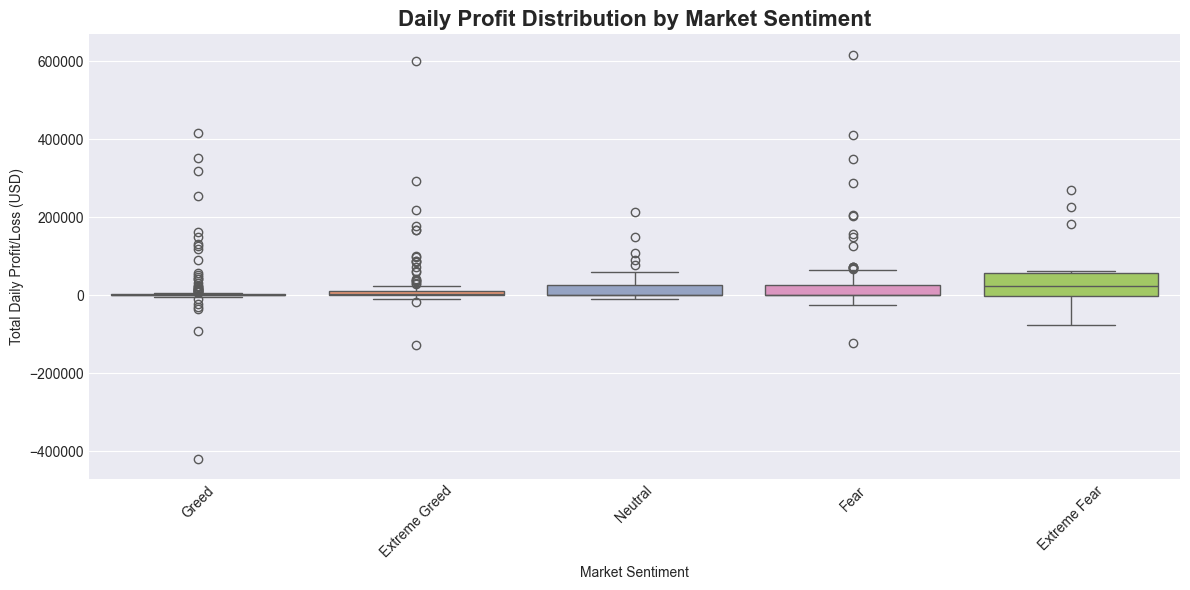

✓ Profit vs sentiment chart saved


In [ ]:
# 2. Profit vs Sentiment
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_df, x='classification', y='Closed PnL_sum', palette='Set2')
plt.title('Daily Profit Distribution by Market Sentiment', fontsize=16, fontweight='bold')
plt.xlabel('Market Sentiment')
plt.ylabel('Total Daily Profit/Loss (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('outputs/02_profit_vs_sentiment.png', dpi=300)
plt.show()
print("✓ Profit vs sentiment chart saved")

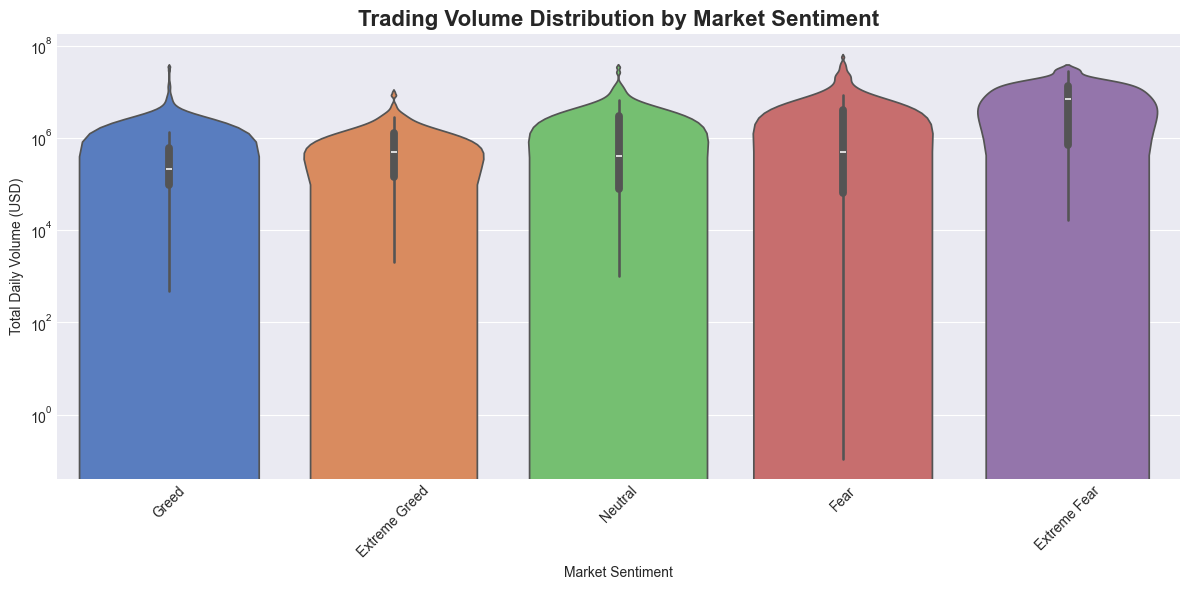

✓ Volume vs sentiment chart saved


In [ ]:
# 3. Trading Volume vs Sentiment
plt.figure(figsize=(12, 6))
sns.violinplot(data=merged_df, x='classification', y='total_daily_volume', palette='muted')
plt.title('Trading Volume Distribution by Market Sentiment', fontsize=16, fontweight='bold')
plt.xlabel('Market Sentiment')
plt.ylabel('Total Daily Volume (USD)')
plt.yscale('log')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('outputs/03_volume_vs_sentiment.png', dpi=300)
plt.show()
print("✓ Volume vs sentiment chart saved")

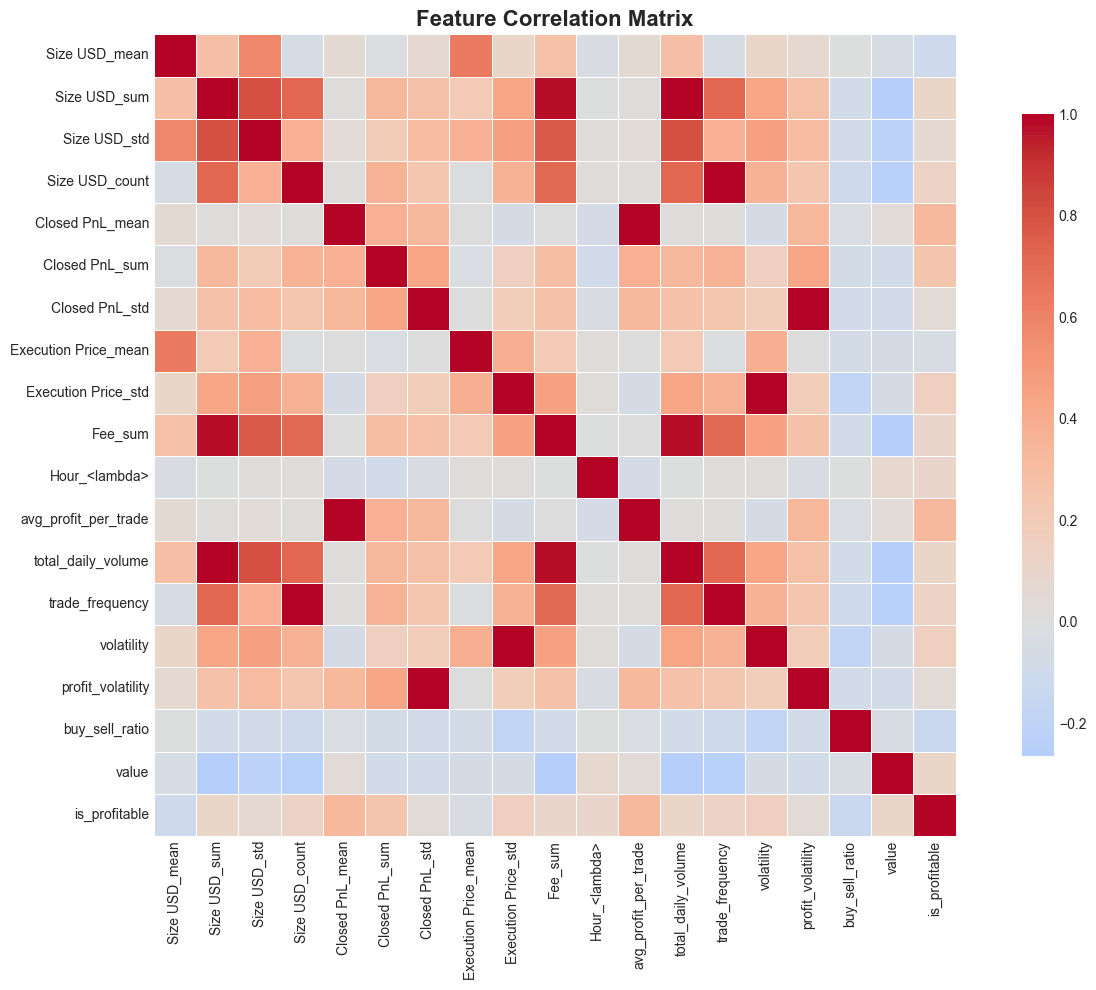

✓ Correlation matrix saved


In [ ]:
# 4. Correlation Heatmap
plt.figure(figsize=(14, 10))
numeric_cols = merged_df.select_dtypes(include=[np.number]).columns
corr_matrix = merged_df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('outputs/04_correlation_matrix.png', dpi=300)
plt.show()
print("✓ Correlation matrix saved")

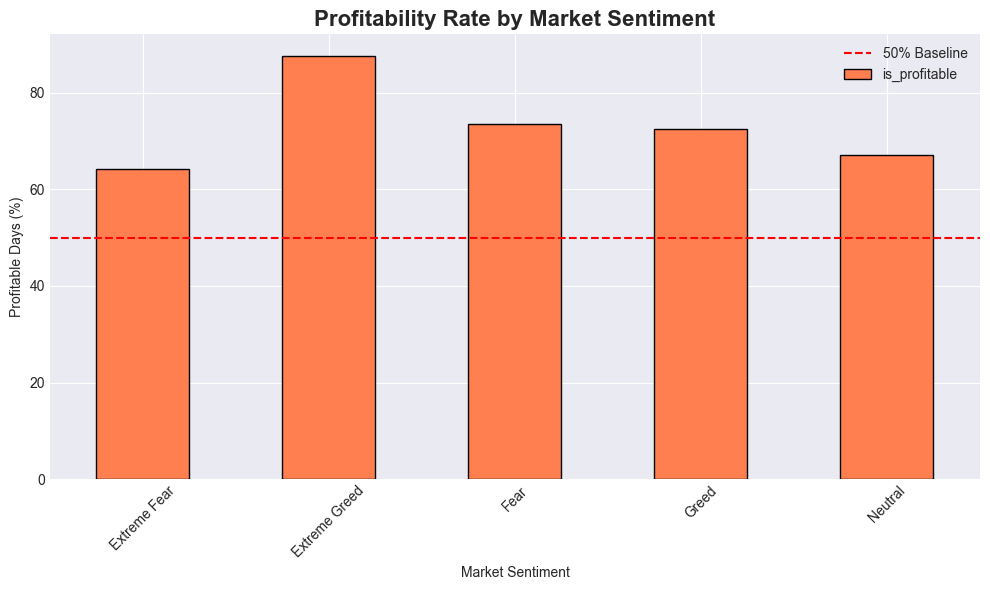

✓ Profitability rate chart saved


In [ ]:
# 5. Profitability Rate by Sentiment
profit_by_sentiment = merged_df.groupby('classification')['is_profitable'].mean() * 100
plt.figure(figsize=(10, 6))
profit_by_sentiment.plot(kind='bar', color='coral', edgecolor='black')
plt.title('Profitability Rate by Market Sentiment', fontsize=16, fontweight='bold')
plt.xlabel('Market Sentiment')
plt.ylabel('Profitable Days (%)')
plt.xticks(rotation=45)
plt.axhline(y=50, color='red', linestyle='--', label='50% Baseline')
plt.legend()
plt.tight_layout()
plt.savefig('outputs/05_profitability_rate.png', dpi=300)
plt.show()
print("✓ Profitability rate chart saved")

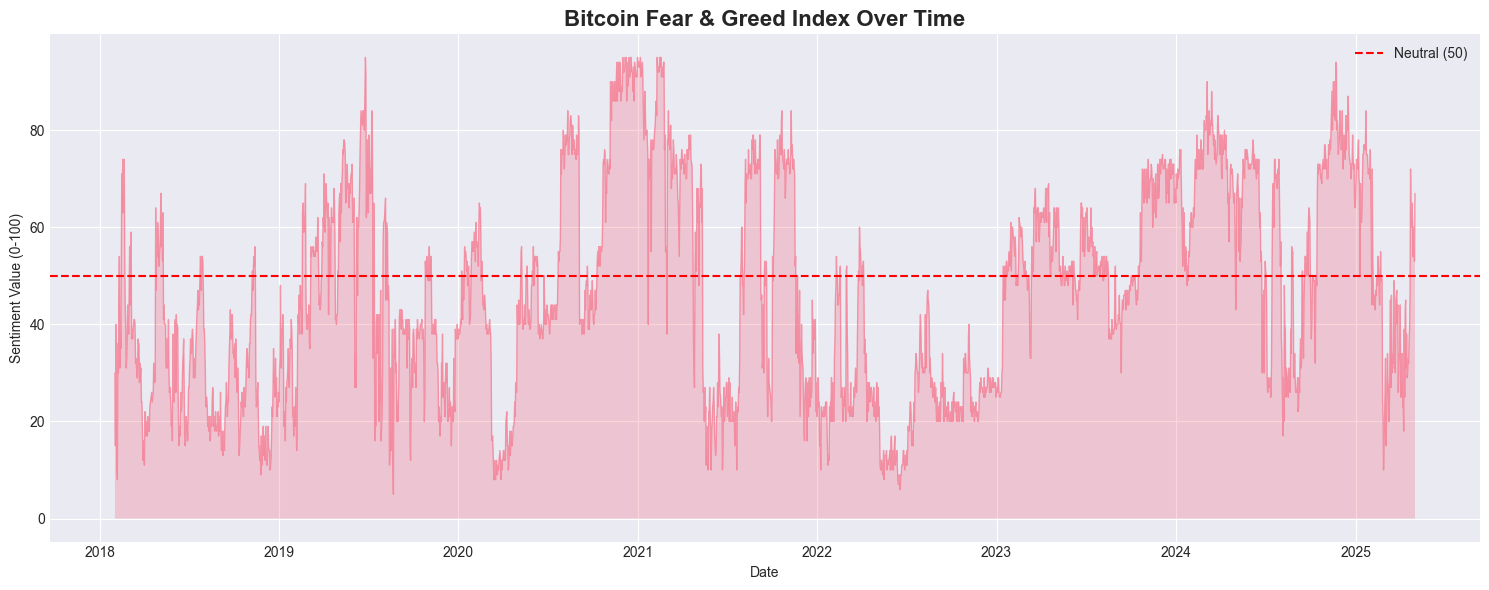

✓ Time series chart saved


24303

In [ ]:
# 6. Sentiment Time Series
plt.figure(figsize=(15, 6))
sentiment_df_sorted = sentiment_df.sort_values('date')
plt.plot(sentiment_df_sorted['date'], sentiment_df_sorted['value'], linewidth=1, alpha=0.7)
plt.fill_between(sentiment_df_sorted['date'], sentiment_df_sorted['value'], alpha=0.3)
plt.title('Bitcoin Fear & Greed Index Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Sentiment Value (0-100)')
plt.axhline(y=50, color='red', linestyle='--', label='Neutral (50)')
plt.legend()
plt.tight_layout()
plt.savefig('outputs/06_sentiment_timeseries.png', dpi=300)
plt.show()
print("✓ Time series chart saved")

# Clear memory
del sentiment_df_sorted
gc.collect()

## 7️⃣ Prepare Data for Machine Learning

In [ ]:
print("[STEP 5] Preparing Data for Machine Learning...")

from sklearn.preprocessing import LabelEncoder

# Encode sentiment first
le = LabelEncoder()
merged_df['sentiment_encoded'] = le.fit_transform(
    merged_df['classification'].fillna('unknown')
)

# Select features
feature_columns = [
    'Size USD_mean', 'Size USD_sum', 'Size USD_std', 'Size USD_count',
    'Closed PnL_mean', 'Closed PnL_std',
    'Execution Price_mean', 'Execution Price_std',
    'Fee_sum', 'Hour',
    'value',
    'avg_profit_per_trade', 'total_daily_volume', 'trade_frequency',
    'volatility', 'profit_volatility'
]

if 'buy_sell_ratio' in merged_df.columns:
    feature_columns.append('buy_sell_ratio')

feature_columns.append('sentiment_encoded')

# Feature matrix and target
X = merged_df[feature_columns].fillna(0).copy()
y = merged_df['is_profitable']

print(f"✓ Feature Matrix Shape: {X.shape}")
print(f"✓ Target Shape: {y.shape}")
print(f"\nFeatures: {list(X.columns)}")


[STEP 5] Preparing Data for Machine Learning...


KeyError: "['Hour'] not in index"

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✓ Training set: {X_train.shape}")
print(f"✓ Test set: {X_test.shape}")
print(f"✓ Features: {len(feature_columns) + 1}")

## 8️⃣ Train Machine Learning Models

We'll train 5 different models with hyperparameter tuning

In [ ]:
# Setup
results = {}
os.makedirs('models', exist_ok=True)
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("[STEP 6] Training Multiple ML Models with Hyperparameter Tuning...")
print("This may take 10-30 minutes depending on your hardware...\n")

In [ ]:
# Model 1: Logistic Regression
print("🔹 Training Logistic Regression...")
lr_params = {'C': [0.01, 0.1, 1, 10], 'max_iter': [1000]}
lr = GridSearchCV(LogisticRegression(random_state=42), lr_params, cv=cv_strategy, scoring='accuracy', n_jobs=-1)
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)

results['Logistic Regression'] = {
    'model': lr.best_estimator_,
    'accuracy': accuracy_score(y_test, lr_pred),
    'precision': precision_score(y_test, lr_pred),
    'recall': recall_score(y_test, lr_pred),
    'f1': f1_score(y_test, lr_pred),
    'roc_auc': roc_auc_score(y_test, lr.predict_proba(X_test_scaled)[:, 1])
}
print(f"  ✓ Accuracy: {results['Logistic Regression']['accuracy']:.4f}")
print(f"  ✓ Best params: {lr.best_params_}")

# Clear memory
gc.collect()

In [ ]:
# Model 2: Random Forest
print("\n🔹 Training Random Forest...")
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=cv_strategy, scoring='accuracy', n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

results['Random Forest'] = {
    'model': rf.best_estimator_,
    'accuracy': accuracy_score(y_test, rf_pred),
    'precision': precision_score(y_test, rf_pred),
    'recall': recall_score(y_test, rf_pred),
    'f1': f1_score(y_test, rf_pred),
    'roc_auc': roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
}
print(f"  ✓ Accuracy: {results['Random Forest']['accuracy']:.4f}")
print(f"  ✓ Best params: {rf.best_params_}")

gc.collect()

In [ ]:
# Model 3: XGBoost
print("\n🔹 Training XGBoost...")
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0]
}
xgb = GridSearchCV(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
                   xgb_params, cv=cv_strategy, scoring='accuracy', n_jobs=-1)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

results['XGBoost'] = {
    'model': xgb.best_estimator_,
    'accuracy': accuracy_score(y_test, xgb_pred),
    'precision': precision_score(y_test, xgb_pred),
    'recall': recall_score(y_test, xgb_pred),
    'f1': f1_score(y_test, xgb_pred),
    'roc_auc': roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1])
}
print(f"  ✓ Accuracy: {results['XGBoost']['accuracy']:.4f}")
print(f"  ✓ Best params: {xgb.best_params_}")

gc.collect()

In [ ]:
# Model 4: LightGBM
print("\n🔹 Training LightGBM...")
lgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'num_leaves': [31, 50, 70]
}
lgb = GridSearchCV(LGBMClassifier(random_state=42, verbose=-1),
                   lgb_params, cv=cv_strategy, scoring='accuracy', n_jobs=-1)
lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_test)

results['LightGBM'] = {
    'model': lgb.best_estimator_,
    'accuracy': accuracy_score(y_test, lgb_pred),
    'precision': precision_score(y_test, lgb_pred),
    'recall': recall_score(y_test, lgb_pred),
    'f1': f1_score(y_test, lgb_pred),
    'roc_auc': roc_auc_score(y_test, lgb.predict_proba(X_test)[:, 1])
}
print(f"  ✓ Accuracy: {results['LightGBM']['accuracy']:.4f}")
print(f"  ✓ Best params: {lgb.best_params_}")

gc.collect()

In [ ]:
# Model 5: Gradient Boosting
print("\n🔹 Training Gradient Boosting...")
gb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}
gb = GridSearchCV(GradientBoostingClassifier(random_state=42),
                  gb_params, cv=cv_strategy, scoring='accuracy', n_jobs=-1)
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)

results['Gradient Boosting'] = {
    'model': gb.best_estimator_,
    'accuracy': accuracy_score(y_test, gb_pred),
    'precision': precision_score(y_test, gb_pred),
    'recall': recall_score(y_test, gb_pred),
    'f1': f1_score(y_test, gb_pred),
    'roc_auc': roc_auc_score(y_test, gb.predict_proba(X_test)[:, 1])
}
print(f"  ✓ Accuracy: {results['Gradient Boosting']['accuracy']:.4f}")
print(f"  ✓ Best params: {gb.best_params_}")

gc.collect()
print("\n✅ All models trained successfully!")

## 9️⃣ Model Comparison and Selection

In [ ]:
print("[STEP 7] Model Comparison and Selection...")

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'F1-Score': [results[m]['f1'] for m in results.keys()],
    'ROC-AUC': [results[m]['roc_auc'] for m in results.keys()]
})
comparison_df = comparison_df.sort_values('Accuracy', ascending=False)

print("\n📊 Model Performance Comparison:")
display(comparison_df)

In [ ]:
# Visualize model comparison
plt.figure(figsize=(14, 8))
x = np.arange(len(comparison_df))
width = 0.15

plt.bar(x - 2*width, comparison_df['Accuracy'], width, label='Accuracy', color='skyblue')
plt.bar(x - width, comparison_df['Precision'], width, label='Precision', color='lightgreen')
plt.bar(x, comparison_df['Recall'], width, label='Recall', color='lightcoral')
plt.bar(x + width, comparison_df['F1-Score'], width, label='F1-Score', color='gold')
plt.bar(x + 2*width, comparison_df['ROC-AUC'], width, label='ROC-AUC', color='plum')

plt.xlabel('Models', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Model Performance Comparison', fontsize=16, fontweight='bold')
plt.xticks(x, comparison_df['Model'], rotation=45, ha='right')
plt.legend()
plt.ylim(0, 1.1)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('outputs/07_model_comparison.png', dpi=300)
plt.show()
print("✓ Model comparison chart saved")

In [ ]:
# Select and save best model
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Accuracy: {comparison_df.iloc[0]['Accuracy']:.4f}")

# Save models
joblib.dump(best_model, 'models/best_model.pkl')
joblib.dump(scaler, 'models/scaler.pkl')
joblib.dump(feature_columns + ['sentiment_encoded'], 'models/feature_columns.pkl')
print(f"\n✓ Best model saved to models/best_model.pkl")

In [ ]:
# Classification report
if best_model_name == 'Logistic Regression':
    best_pred = lr.predict(X_test_scaled)
else:
    best_pred = results[best_model_name]['model'].predict(X_test)

print("\n📋 Detailed Classification Report (Best Model):")
print(classification_report(y_test, best_pred, target_names=['Not Profitable', 'Profitable']))

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, best_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Profitable', 'Profitable'],
            yticklabels=['Not Profitable', 'Profitable'])
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=16, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('outputs/08_confusion_matrix.png', dpi=300)
plt.show()
print("✓ Confusion matrix saved")

In [ ]:
# ROC Curves for all models
plt.figure(figsize=(10, 6))
for model_name in results.keys():
    if model_name == 'Logistic Regression':
        y_pred_proba = results[model_name]['model'].predict_proba(X_test_scaled)[:, 1]
    else:
        y_pred_proba = results[model_name]['model'].predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = results[model_name]['roc_auc']
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - All Models', fontsize=16, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('outputs/09_roc_curves.png', dpi=300)
plt.show()
print("✓ ROC curves saved")

In [ ]:
# Feature Importance (for tree-based models)
if best_model_name in ['Random Forest', 'XGBoost', 'LightGBM', 'Gradient Boosting']:
    feature_importance = pd.DataFrame({
        'Feature': feature_columns + ['sentiment_encoded'],
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False).head(15)

    plt.figure(figsize=(10, 8))
    sns.barplot(data=feature_importance, x='Importance', y='Feature', palette='viridis')
    plt.title(f'Top 15 Feature Importances - {best_model_name}', fontsize=16, fontweight='bold')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.savefig('outputs/10_feature_importance.png', dpi=300)
    plt.show()

    print("\n📊 Top 10 Feature Importances:")
    display(feature_importance.head(10))
    print("✓ Feature importance chart saved")

## 🔟 Summary and Next Steps

In [ ]:
print("\n" + "=" * 80)
print("ANALYSIS COMPLETE!")
print("=" * 80)

print("\n📈 KEY INSIGHTS:")
print(f"1. Total trading records analyzed: {len(trader_df):,}")
print(f"2. Unique trading days: {merged_df.shape[0]}")
print(f"3. Overall profitability rate: {(merged_df['is_profitable'].mean() * 100):.2f}%")
print(f"4. Best performing model: {best_model_name}")
print(f"5. Model accuracy: {comparison_df.iloc[0]['Accuracy']:.4f}")

print("\n📁 OUTPUT FILES:")
print("  ✓ 10 visualization charts saved to outputs/")
print("  ✓ Best ML model saved to models/best_model.pkl")
print("  ✓ Scaler saved to models/scaler.pkl")
print("  ✓ Feature columns saved to models/feature_columns.pkl")

print("\n🚀 Next Steps:")
print("  1. Review visualizations in outputs/ folder")
print("  2. Use the saved model for predictions via Streamlit dashboard")
print("  3. Run: streamlit run streamlit_app.py")
print("  4. Consider feature engineering for improved accuracy")

print("\n" + "=" * 80)